In [1]:
# === Environment Setup ===
!pip install prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
try:
    import pandas_datareader.data as web
    PDR_AVAILABLE = True
except ImportError:
    PDR_AVAILABLE = False
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import display, Markdown

# --- Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8), 'figure.dpi': 150})
np.set_printoptions(suppress=True, linewidth=120, precision=4)

# --- Utility Functions ---
def note(msg): display(Markdown(f"<div class='alert alert-info'>📝 {msg}</div>"))
def sec(title): print(f'\n{80*"="}\n| {title.upper()} |\n{80*"="}')

note("Environment initialized for ARIMA and Forecasting.")

<div class='alert alert-info'>📝 Environment initialized for ARIMA and Forecasting.</div>

# Chapter 8.3: ARIMA Models and Forecasting

---

### Table of Contents

1.  [**Introduction: Handling Non-Stationary Time Series**](#intro)
2.  [**Integrated Processes and Differencing**](#integrated)
    - [The Random Walk: A Prototypical I(1) Process](#random-walk)
3.  [**The Box-Jenkins Methodology**](#box-jenkins)
4.  [**The ARIMA(p,d,q) Model**](#arima)
5.  [**Forecasting with ARIMA**](#forecasting)
    - [Case Study: Forecasting US Industrial Production](#case-study)
6.  [**Model Validation and Evaluation**](#validation)
    - [Time Series Cross-Validation](#cv)
    - [Code Lab: Evaluating Forecast Accuracy](#code-cv)
7.  [**Automated Forecasting with Prophet**](#prophet)
8.  [**Exercises**](#exercises)
9.  [**Summary and Key Takeaways**](#summary)


### First Principles: The Components of Prophet

`Prophet` is a decomposable time series model, which means it models a series \(y(t)\) as a sum of several distinct components. This makes the model highly interpretable.
$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$
Where:
- **\(g(t)\) - Trend:** This is the non-periodic, long-term direction of the series. Prophet models this with a piecewise linear or logistic growth curve. A key feature is its ability to automatically detect 'changepoints' where the trend's growth rate changes.
- **\(s(t)\) - Seasonality:** This component captures predictable patterns that repeat over a specific period (e.g., yearly, weekly, daily). It is modeled using a flexible Fourier series, which can fit complex seasonal effects.
- **\(h(t)\) - Holidays:** This is a special, user-specified component to model the effects of holidays and unique events that don't follow a regular seasonal pattern (e.g., Black Friday, a product launch). This allows the model to account for known irregularities.
- **\(\epsilon_t\) - Error:** This is an idiosyncratic error term, assumed to be normally distributed, which captures any random fluctuations not explained by the other components.


### First Principles: Information Criteria (AIC & BIC)

When comparing different ARIMA(p,d,q) models, we need a way to balance model fit with model complexity. A model with more parameters (higher `p` or `q`) will almost always fit the training data better, but it may be overfitting and will likely perform poorly on new data (a concept known as the bias-variance tradeoff).

**Information Criteria** are statistical measures that formalize this tradeoff. They provide a single number to judge a model, where a lower value is better. The two most common are:

1.  **Akaike Information Criterion (AIC):** \( AIC = 2k - 2\ln(\hat{L}) \)
2.  **Bayesian Information Criterion (BIC):** \( BIC = k\ln(n) - 2\ln(\hat{L}) \)

Where:
- \(k\) is the number of model parameters (e.g., `p + q`).
- \(\hat{L}\) is the maximized value of the likelihood function (a measure of model fit).
- \(n\) is the number of data points.

The first term in each equation is a **penalty for complexity**. Notice that the BIC's penalty, \(k\ln(n)\), is stronger than the AIC's penalty, \(2k\), especially for larger datasets (as \(\ln(n)\) grows). This means the BIC tends to favor more parsimonious (simpler) models than the AIC.


### Intellectual Provenance: Box & Jenkins

The process of identifying the appropriate `(p, d, q)` orders, estimating the model, and then checking the residuals is a formal methodology developed by statisticians George Box and Gwilym Jenkins in their seminal 1970 book, *Time Series Analysis: Forecasting and Control*. This iterative, three-stage approach became the foundation of classical time series analysis, providing a rigorous and structured workflow that moved the field from ad-hoc methods to a systematic science.


### First Principles: The Lag Operator (L)

In time series analysis, the **Lag Operator**, denoted by \(L\), is a mathematical shorthand used to represent the value of a variable in the previous time period. Applying the operator to a time series \(y_t\) gives its value at time \(t-1\):

$$ Ly_t = y_{t-1} $$

Applying it twice gives the value from two periods ago, \(L^2y_t = y_{t-2}\), and so on. This operator simplifies the notation for ARMA models. For example, an AR(1) process, \(y_t = c + \phi_1 y_{t-1} + \epsilon_t\), can be rewritten using the lag operator as:

$$ (1 - \phi_1 L)y_t = c + \epsilon_t $$


<a id='intro'></a>
## 1. Introduction: Handling Non-Stationary Time Series

The ARMA models we have explored are built on the assumption that the time series is **stationary**. However, most macroeconomic and financial time series are **non-stationary**; they exhibit clear trends or long-term movements that violate the stationarity conditions of constant mean and variance. The most common form of non-stationarity is a **unit root**, which gives rise to stochastic trends.

This chapter introduces the **Autoregressive Integrated Moving Average (ARIMA)** model, which extends the ARMA framework to handle non-stationary data. The central innovation is the **'Integrated' (I)** component. This involves differencing the time series to transform it from a non-stationary process into a stationary one. Once the series is stationary, we can then model the differenced series with a standard ARMA model. This provides a powerful and flexible framework for modeling and forecasting a wide range of real-world economic time series.


<a id='integrated'></a>
## 2. Integrated Processes and Differencing

A time series is said to be **integrated of order d**, denoted **I(d)**, if it needs to be differenced \(d\) times to become stationary. 
- An I(0) series is already stationary.
- An I(1) series needs to be first-differenced to become stationary.
- An I(2) series needs to be differenced twice.

Most trending economic time series are found to be I(1).

<a id='random-walk'></a>
### The Random Walk: A Prototypical I(1) Process
The simplest and most fundamental I(1) process is the **random walk**:
$$ y_t = y_{t-1} + \epsilon_t $$
Where \(\epsilon_t\) is a white noise error term. The value at time \(t\) is simply the previous value plus a random shock. While the mean of a random walk is constant (usually assumed to be zero), its variance, \(Var(y_t) = t \sigma^2_\epsilon\), grows over time, clearly violating the stationarity condition. Shocks to a random walk are **permanent**; they are fully incorporated into the level of the series forever.

The solution is to take the **first difference** of the series:
$$ \Delta y_t = y_t - y_{t-1} = \epsilon_t $$
The differenced series, \(\Delta y_t\), is just a white noise process, which is by definition stationary. Therefore, a random walk is an I(1) process.


<a id='box-jenkins'></a>
## 3. The Box-Jenkins Methodology

The process of identifying the appropriate `(p, d, q)` orders, estimating the model, and then checking the residuals is a formal methodology developed by statisticians George Box and Gwilym Jenkins in their seminal 1970 book, *Time Series Analysis: Forecasting and Control*. This iterative, three-stage process established a new standard for time series analysis:

1.  **Identification:** Use the data, plots (like ACF/PACF), and statistical tests (like the Augmented Dickey-Fuller test) to determine the order of differencing `d` required to achieve stationarity. Then, inspect the ACF and PACF of the differenced series to tentatively select the AR order `p` and MA order `q`.
2.  **Estimation:** Fit the chosen ARIMA(p,d,q) model to the time series data, typically using Maximum Likelihood Estimation (MLE) to find the model coefficients that best match the data.
3.  **Diagnostic Checking:** Analyze the model's residuals. If the model is a good fit, the residuals should behave like white noise (i.e., be uncorrelated with zero mean). If they show remaining structure, the model is misspecified, and one must return to the identification stage to select a different model.

This structured workflow provides a methodical framework for building time series models.


<a id='arima'></a>
## 4. The ARIMA(p,d,q) Model

The ARIMA model combines the differencing step with an ARMA model. An **ARIMA(p,d,q)** model is specified by three orders:
- **p**: The order of the autoregressive component (the number of lags of the differenced series).
- **d**: The order of differencing (the number of times the data needs to be differenced to become stationary).
- **q**: The order of the moving average component (the number of lagged forecast errors).

The process involves determining the order of integration, \(d\), typically by using an Augmented Dickey-Fuller test. Once a stationary series is obtained by differencing \(d\) times, we analyze its ACF and PACF plots to determine the appropriate AR and MA orders, \(p\) and \(q\), for an ARMA model on the differenced data.


<a id='forecasting'></a>
## 5. Forecasting with ARIMA

<a id='case-study'></a>
### Case Study: Forecasting US Industrial Production
We will now apply the full Box-Jenkins methodology to model and forecast the US Industrial Production Index (INDPRO) from the Federal Reserve Economic Data (FRED) database.



| CASE STUDY: FORECASTING US INDUSTRIAL PRODUCTION |


<div class='alert alert-info'>📝 Attempting to download monthly US Industrial Production data from FRED.</div>

<div class='alert alert-info'>📝 Data downloaded successfully.</div>

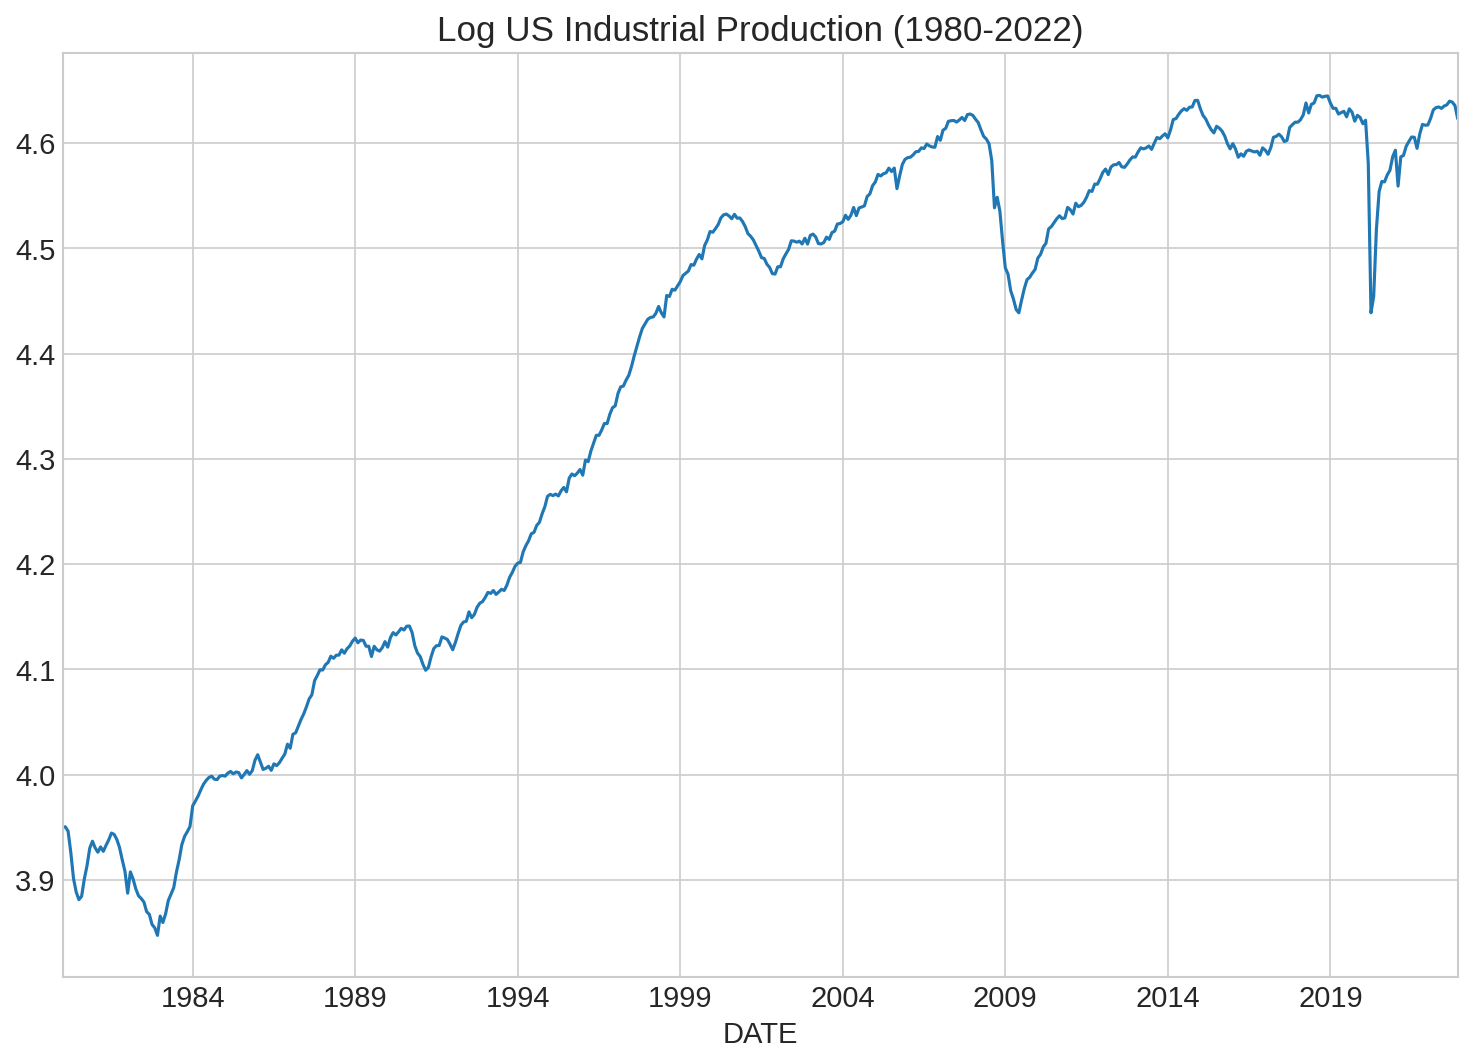

<div class='alert alert-info'>📝 The series clearly shows an upward trend, indicating it is non-stationary.</div>

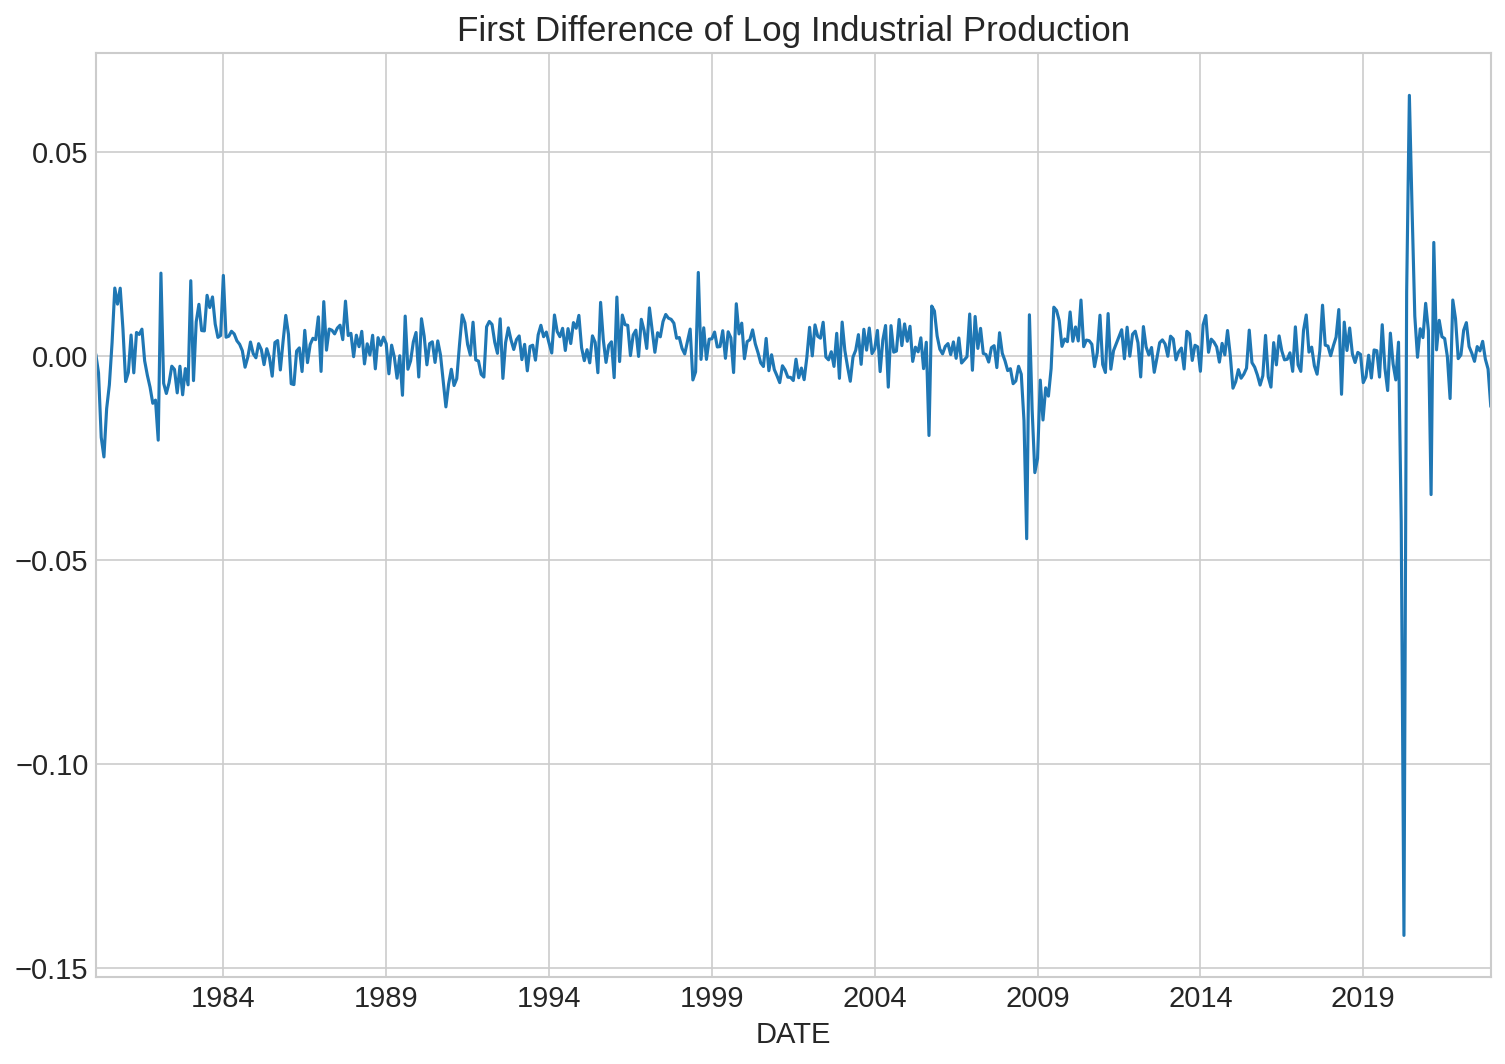

<div class='alert alert-info'>📝 The first difference appears stationary, suggesting d=1. We will now formally test this.</div>


| AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY |
ADF Statistic (Level): -1.4675
p-value (Level): 0.5495


<div class='alert alert-info'>📝 The ADF test's null hypothesis is that a unit root is present. With a high p-value (0.5495), we fail to reject the null. The level series is non-stationary.</div>


ADF Statistic (Difference): -5.7656
p-value (Difference): 0.0000


<div class='alert alert-info'>📝 The p-value is very low (0.0000), so we reject the null hypothesis. The differenced series is stationary.</div>

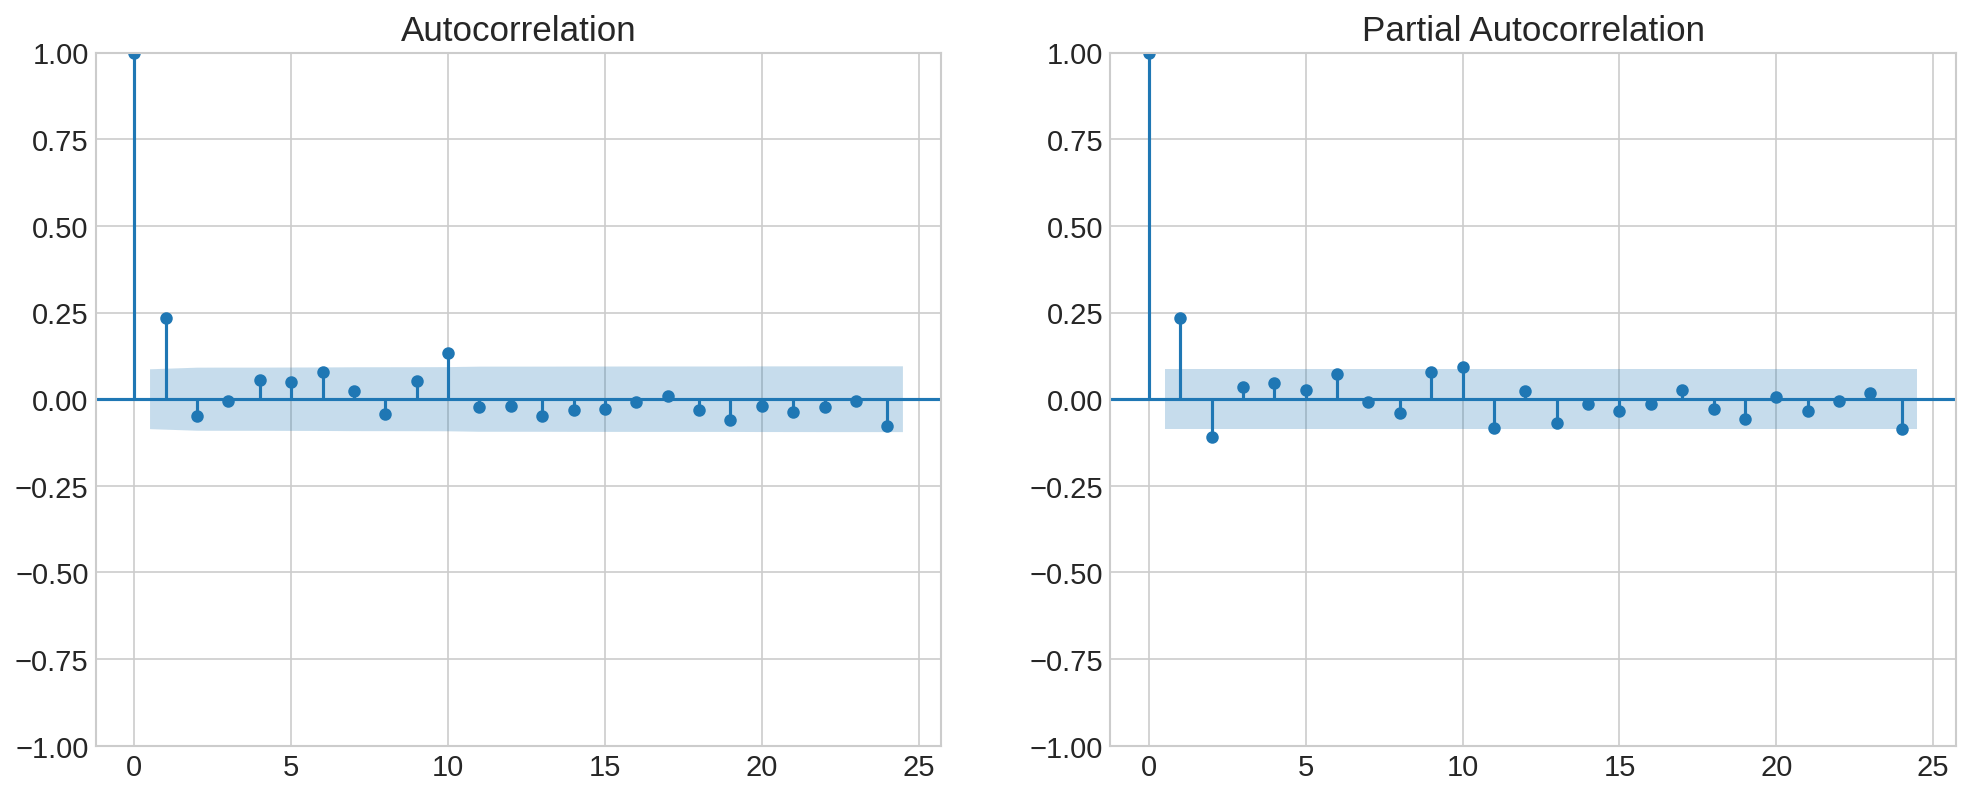

<div class='alert alert-info'>📝 The ACF and PACF plots both appear to tail off, suggesting a mixed ARMA model is appropriate.</div>

<div class='alert alert-info'>📝 Based on the plots, we will try an ARIMA(1,1,1) model.</div>

                               SARIMAX Results                                
Dep. Variable:                 INDPRO   No. Observations:                  516
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1653.937
Date:                Thu, 23 Oct 2025   AIC                          -3301.874
Time:                        08:10:59   BIC                          -3289.142
Sample:                    01-01-1980   HQIC                         -3296.884
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1311      0.056     -2.355      0.019      -0.240      -0.022
ma.L1          0.4073      0.055      7.344      0.000       0.299       0.516
sigma2      9.503e-05   1.24e-06     76.597      0.0

<div class='alert alert-info'>📝 Generating out-of-sample forecasts for the next 24 months.</div>

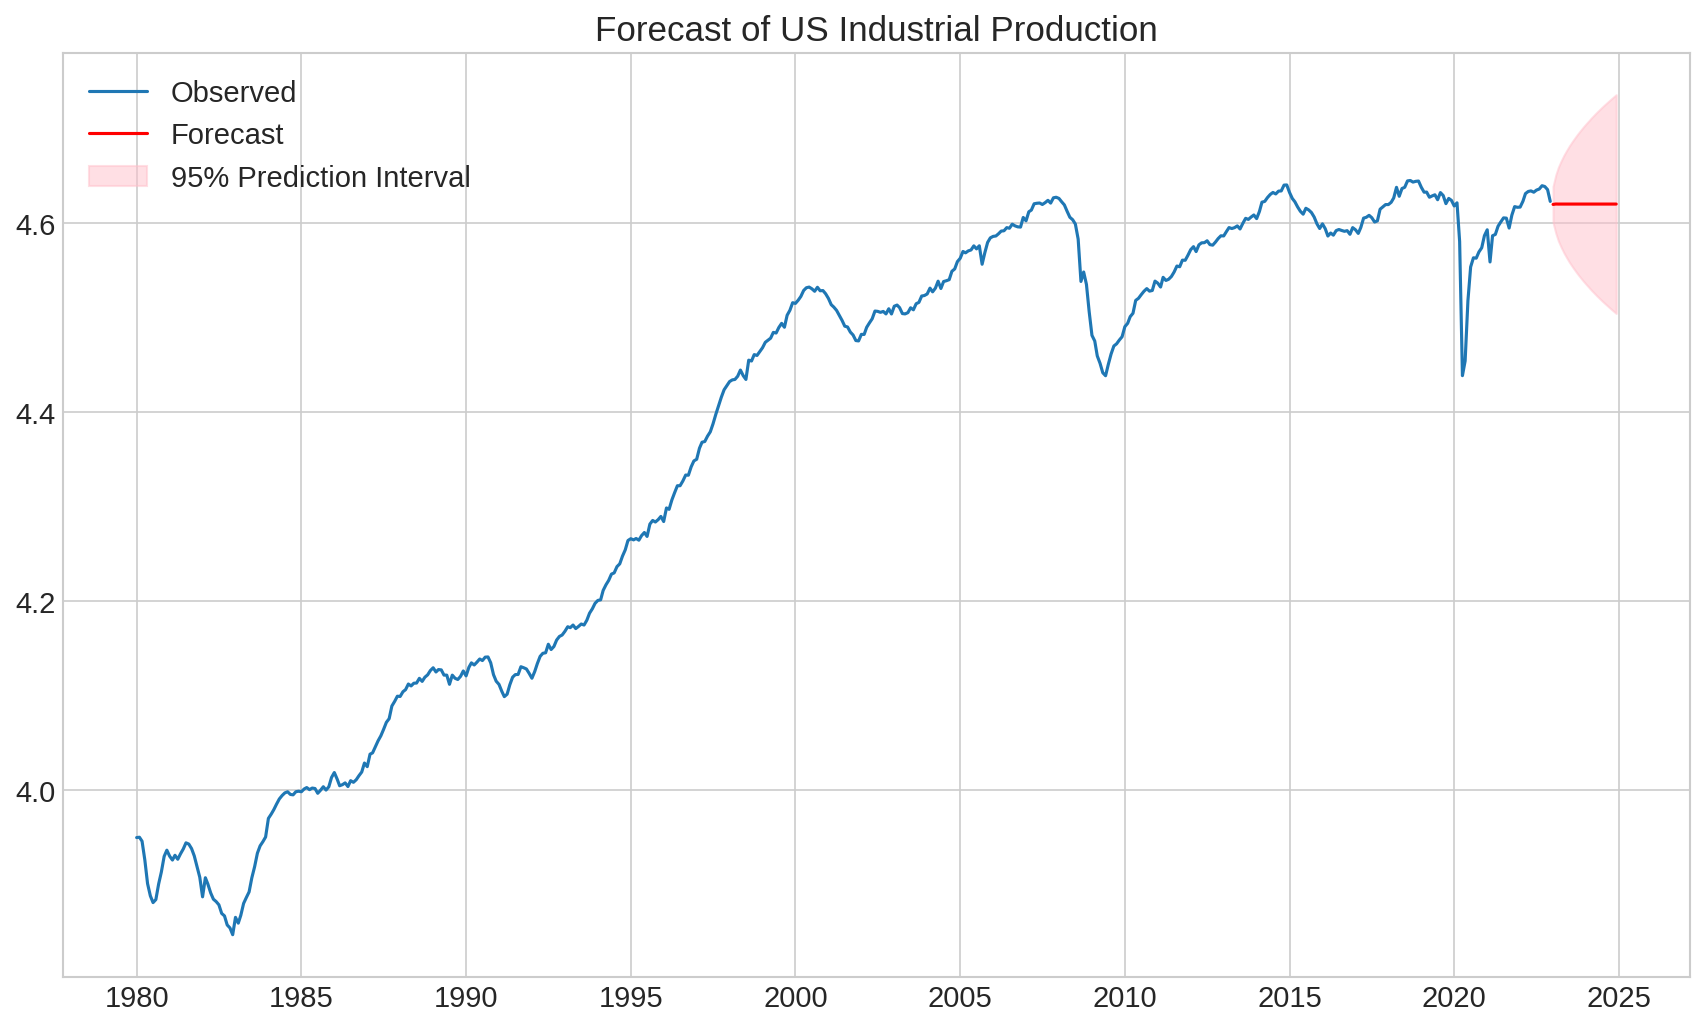

In [2]:
sec("Case Study: Forecasting US Industrial Production")

# 1. Load and plot the data
if PDR_AVAILABLE:
    note("Attempting to download monthly US Industrial Production data from FRED.")
    try:
        start = '1980-01-01'
        end = '2022-12-31'
        indpro = web.DataReader('INDPRO', 'fred', start, end)
        indpro.index.freq = 'MS'
        log_indpro = np.log(indpro['INDPRO'])
        note("Data downloaded successfully.")
    except Exception as e:
        note(f"Could not download data from FRED ({e}). Falling back to local CSV.")
        indpro = pd.read_csv('../data/INDPRO.csv', index_col='observation_date', parse_dates=True)
        indpro = indpro.loc['1980-01-01':'2022-12-31']
        log_indpro = np.log(indpro['INDPRO'])
else:
    note("pandas_datareader not available. Loading data from local CSV.")
    indpro = pd.read_csv('../data/INDPRO.csv', index_col='observation_date', parse_dates=True)
    indpro = indpro.loc['1980-01-01':'2022-12-31']
    log_indpro = np.log(indpro['INDPRO'])

log_indpro.plot(title='Log US Industrial Production (1980-2022)')
plt.show()
note("The series clearly shows an upward trend, indicating it is non-stationary.")

# 2. Difference the data to achieve stationarity
d_log_indpro = log_indpro.diff().dropna()
d_log_indpro.plot(title='First Difference of Log Industrial Production')
plt.show()
note("The first difference appears stationary, suggesting d=1. We will now formally test this.")

# 2a. Formal Test for Stationarity (Augmented Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller
sec("Augmented Dickey-Fuller Test for Stationarity")

adf_test_level = adfuller(log_indpro)
print(f'ADF Statistic (Level): {adf_test_level[0]:.4f}')
print(f'p-value (Level): {adf_test_level[1]:.4f}')
note(f"The ADF test's null hypothesis is that a unit root is present. With a high p-value ({adf_test_level[1]:.4f}), we fail to reject the null. The level series is non-stationary.")

# Test on the differenced series
adf_test_diff = adfuller(d_log_indpro)
print(f'\nADF Statistic (Difference): {adf_test_diff[0]:.4f}')
print(f'p-value (Difference): {adf_test_diff[1]:.4f}')
note(f"The p-value is very low ({adf_test_diff[1]:.4f}), so we reject the null hypothesis. The differenced series is stationary.")

# 3. Identify AR and MA orders using ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(d_log_indpro, ax=ax1, lags=24)
plot_pacf(d_log_indpro, ax=ax2, lags=24)
plt.show()
note("The ACF and PACF plots both appear to tail off, suggesting a mixed ARMA model is appropriate.")

# 4. Estimate the ARIMA model
note("Based on the plots, we will try an ARIMA(1,1,1) model.")
model = ARIMA(log_indpro, order=(1, 1, 1))
results = model.fit()
print(results.summary())

# 5. Generate and plot forecasts
note("Generating out-of-sample forecasts for the next 24 months.")
forecast_obj = results.get_forecast(steps=24)
forecast_ci = forecast_obj.conf_int()

plt.figure(figsize=(14, 8))
plt.plot(log_indpro, label='Observed')
plt.plot(forecast_obj.predicted_mean, label='Forecast', color='r')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='95% Prediction Interval')
plt.title('Forecast of US Industrial Production')
plt.legend()
plt.show()

<a id='validation'></a>
## 6. Model Validation and Evaluation

While the Box-Jenkins/ARIMA methodology is a powerful approach, it's important to know how to properly validate its performance and to be aware of automated alternatives.

<a id='cv'></a>
### 6.1 Time Series Cross-Validation

How can we rigorously evaluate a forecasting model's performance on unseen data? For non-temporal data, we often use k-fold cross-validation, which randomly splits the data into training and testing sets. This is **incorrect** for time series data, as it would involve training the model on future data to predict the past, leading to unrealistic performance metrics.

The standard approach is **expanding window cross-validation** (or forward chaining). This procedure correctly mimics a real-world forecasting scenario:
1. Start with an initial block of data for training.
2. Make a forecast for the next period (the test set).
3. 'Expand the window' by adding the test data to the training set.
4. Repeat the process, always using the past to predict the future.

Scikit-learn's `TimeSeriesSplit` implements this logic. The visualization below shows how each fold uses a progressively larger training set to forecast a subsequent, non-overlapping test set.

![TimeSeriesSplit Visualization](../images/08-Time-Series/timeseries_split_visualization.png)


<a id='code-cv'></a>
### 6.2 Code Lab: Evaluating Forecast Accuracy

Let's use the expanding window approach to evaluate the 1-step-ahead forecast accuracy of our ARIMA(1,1,1) model for industrial production. We'll calculate the Root Mean Squared Error (RMSE) across all the test folds.


In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

sec("Evaluating ARIMA(1,1,1) with Time Series Cross-Validation")

X = log_indpro.values
tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_index, test_index in tscv.split(X):
    cv_train, cv_test = X[train_index], X[test_index]
    
    # Fit the model on the training data
    model_cv = ARIMA(cv_train, order=(1, 1, 1))
    results_cv = model_cv.fit()
    
    # Forecast the next step
    forecast = results_cv.forecast(steps=len(cv_test))
    
    # Calculate the error
    error = mean_squared_error(cv_test, forecast)
    errors.append(error)

rmse_arima = np.sqrt(np.mean(errors))
note(f"The cross-validated Root Mean Squared Error (RMSE) for our ARIMA(1,1,1) model is: {rmse_arima:.6f}")


| EVALUATING ARIMA(1,1,1) WITH TIME SERIES CROSS-VALIDATION |


/home/jules/.pyenv/versions/3.12.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<div class='alert alert-info'>📝 The cross-validated Root Mean Squared Error (RMSE) for our ARIMA(1,1,1) model is: 0.111333</div>

<a id='prophet'></a>
## 7. Automated Forecasting with Prophet

The Box-Jenkins methodology requires careful manual steps (differencing, interpreting ACF/PACF plots, checking residuals). In many business applications, a more automated and scalable approach is desired. Facebook's `Prophet` library was developed for this purpose, prioritizing scalability and ease of use.

`Prophet` is a decomposable time series model that models a series \(y(t)\) as a sum of several components:
$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$
- **\(g(t)\) - Trend:** A piecewise linear or logistic growth curve. Prophet automatically detects changepoints in the trend.
- **\(s(t)\) - Seasonality:** A periodic component modeled with Fourier series (e.g., yearly, weekly, daily seasonality).
- **\(h(t)\) - Holidays:** A flexible component to model the effects of holidays and special events, which can be customized.
- **\(\epsilon_t\) - Error:** A normally distributed error term.

Its primary advantage is its ability to produce a reliable baseline forecast, complete with uncertainty intervals, with minimal manual tuning. Let's apply it to our industrial production data and compare its out-of-sample RMSE to our ARIMA model.


08:11:01 - cmdstanpy - INFO - Chain [1] start processing


08:11:01 - cmdstanpy - INFO - Chain [1] done processing


<div class='alert alert-info'>📝 The out-of-sample Root Mean Squared Error (RMSE) for Prophet is: 0.024711</div>

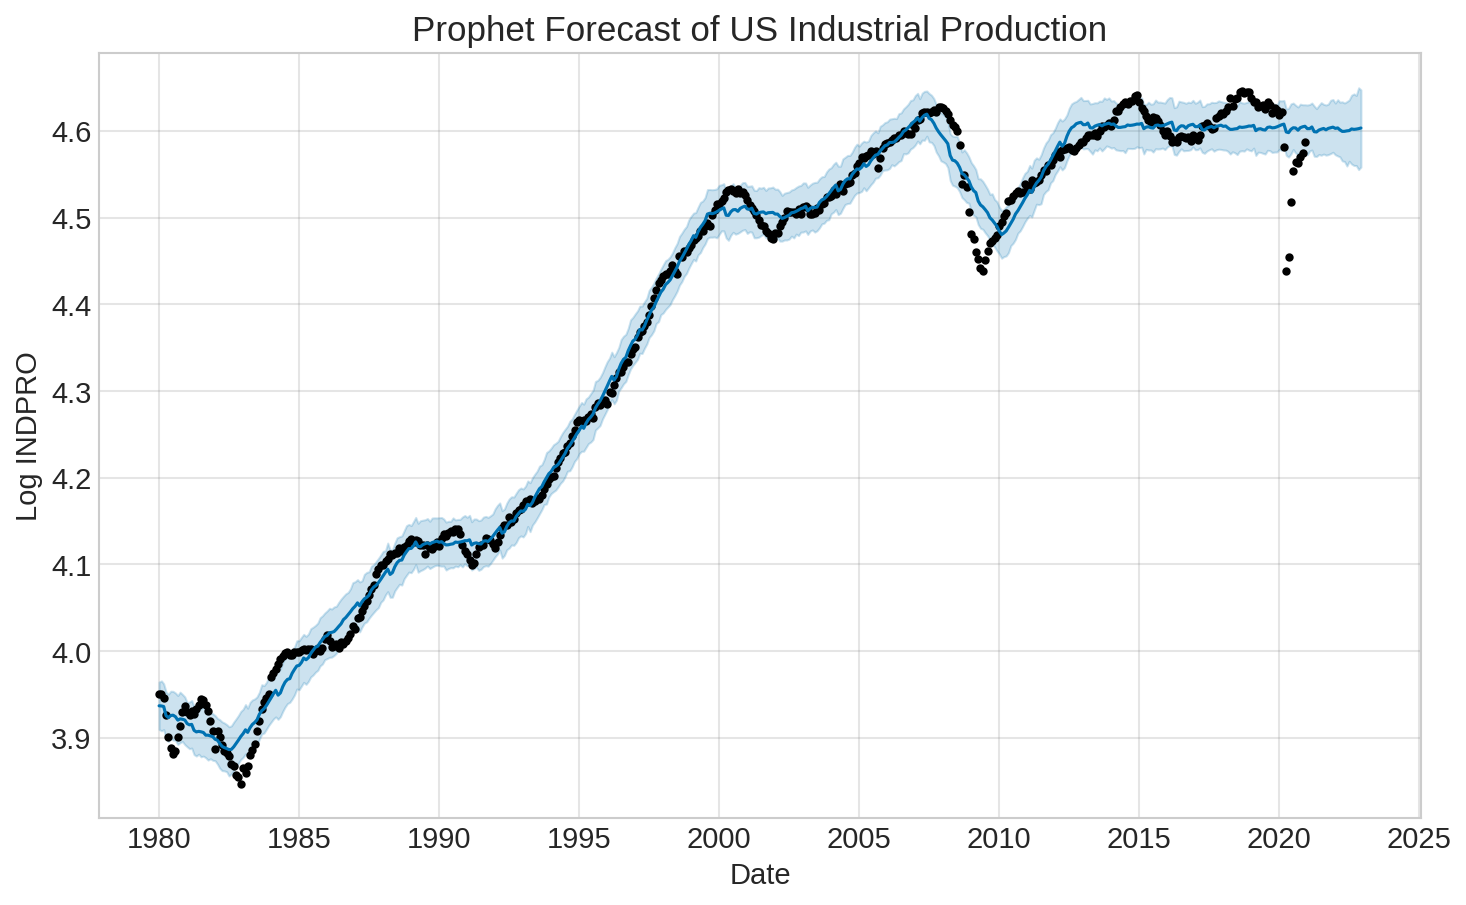

In [4]:
from prophet import Prophet
import logging
# Suppress verbose output from Prophet
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

prophet_df = log_indpro.reset_index()
prophet_df.columns = ['ds', 'y']
train_df = prophet_df.iloc[:-24]

# Instantiate and fit the model
model_prophet = Prophet()
model_prophet.fit(train_df)

# Create a future dataframe to forecast into
future = model_prophet.make_future_dataframe(periods=24, freq='MS')
forecast_prophet = model_prophet.predict(future)

from sklearn.metrics import mean_squared_error
y_true = prophet_df['y'][-24:].values
y_pred = forecast_prophet['yhat'][-24:].values
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

note(f"The out-of-sample Root Mean Squared Error (RMSE) for Prophet is: {rmse_prophet:.6f}")
fig = model_prophet.plot(forecast_prophet)
plt.title('Prophet Forecast of US Industrial Production')
plt.xlabel('Date')
plt.ylabel('Log INDPRO')
plt.show()

<a id='exercises'></a>
## 8. Exercises

1.  **Unit Root:** What is the root of the characteristic equation for a random walk process, \(y_t = y_{t-1} + \epsilon_t\)? Where does this root lie with respect to the unit circle?
2.  **Order of Integration:** If a time series \(y_t\) has to be differenced twice to become stationary, what is its order of integration, and what would a plot of the series itself likely look like?
3.  **Forecasting:** Look at the forecast plot for US Industrial Production. What happens to the point forecast over the long run? What happens to the width of the prediction interval? Explain why this is the case.
4.  **Model Selection:** Using the `arma_order_select_ic` function from `statsmodels` (as shown in the previous notebook), find the best ARMA model for the differenced log industrial production series (`d_log_indpro`) according to the BIC. How does it compare to the ARIMA(1,1,1) model we chose?


<a id='summary'></a>\n## 9. Summary and Key Takeaways\n\nThis chapter extended the ARMA framework to non-stationary data using the ARIMA model, which is one of the most widely used tools for time series forecasting.\n\n**Key Concepts**:\n- **Integrated Processes**: A series is integrated of order \(d\), I(d), if it must be differenced \(d\) times to become stationary. Most trending economic time series are I(1).\n- **Differencing**: The key to handling unit root non-stationarity. First-differencing a series (\( \Delta y_t = y_t - y_{t-1} \)) models its changes, which are often stationary.\n- **ARIMA(p,d,q) Models**: A composite model that first differences the data \(d\) times, and then fits an ARMA(p,q) model to the resulting stationary series.\n- **Forecasting**: Once an ARIMA model is estimated, it can be used to produce out-of-sample forecasts. The forecasts will eventually converge to the mean of the differenced series, and the uncertainty (width of the prediction intervals) will grow as the forecast horizon increases.


### Solutions to Exercises\n\n---\n\n**1. Unit Root:**\nThe process is \(y_t - y_{t-1} = \epsilon_t\), which in lag operator notation is \((1-L)y_t = \epsilon_t\). The characteristic equation is \(1-z=0\). The root is \(z=1\). This root lies *on* the unit circle, hence the name "unit root process".\n\n---\n\n**2. Order of Integration:**\nIt is integrated of order 2, or I(2). A plot of an I(2) series will typically show a more explosive, quadratic-like trend compared to the linear trend of an I(1) process.\n\n---\n\n**3. Forecasting:**\nThe point forecast for the log-level will converge to a straight line representing the long-run drift of the series. The prediction interval will continue to widen as the forecast horizon increases. This is because each step ahead adds more uncertainty. The variance of the forecast error for an \(h\)-step-ahead forecast is a function of \(h\); as \(h\) grows, so does the variance, reflecting that we are less certain about the distant future.\n\n---\n\n**4. Model Selection:**\nYou would run `arma_order_select_ic(d_log_indpro, max_ar=3, max_ma=3, ic='bic')`. The results would show a grid of BIC values for all ARMA(p,q) models up to (3,3). You would select the (p,q) combination with the lowest BIC value. This provides a more systematic approach to model selection than relying solely on visual inspection of the ACF/PACF plots.
